<img src="header.png" style="border-radius: 50%; display: block; margin: 0 auto; width: 200px; height: 200px;">
<h1>Hull Tactical - Market Prediction</h1>
<p>Can you predict market predictability?</p>
<h2>Overview</h2>
<p>Your task is to predict the stock market returns as represented by the excess returns of the S&P 500 while also managing volatility constraints. Your work will test the Efficient Market Hypothesis and challenge common tenets of personal finance.</p>
<h3>Source</h3>
<a href="https://www.kaggle.com/competitions/hull-tactical-market-prediction/overview" class="source-link">Source Link</a>

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('datasets/train.csv')
df

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8985,8985,0,0,0,0,0,0,0,0,0,...,0.469577,0.837963,1.226772,0.822751,-0.707361,0.142857,-0.649616,0.002457,0.000155,0.001990
8986,8986,0,0,0,0,0,0,0,0,0,...,0.671958,0.837963,0.785877,0.805556,-0.715692,0.196098,-0.668289,0.002312,0.000156,0.001845
8987,8987,0,0,1,0,0,0,0,0,0,...,0.481481,0.787698,0.834898,0.823413,-0.723949,0.133929,-0.670946,0.002891,0.000156,0.002424
8988,8988,0,0,0,0,0,0,0,0,0,...,0.655423,0.783730,0.994026,0.851852,-0.684937,0.101852,-0.646265,0.008310,0.000156,0.007843


# 1. Data Cleaning

In [3]:
df.shape

(8990, 98)

In [4]:
df.columns

Index(['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1',
       'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19',
       'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3',
       'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13',
       'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7',
       'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5',
       'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4',
       'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2',
       'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'forward_returns',
       'risk_free_rate', 'market_forward_excess_returns'],
      dtype='object')

## 1. Missing Data

In [5]:
df.isna().sum()[df.isna().sum() > 0]


E1     1784
E10    1006
E11    1006
E12    1006
E13    1006
       ... 
V5     1512
V6     1006
V7     1511
V8     1006
V9     4539
Length: 85, dtype: int64

In [ ]:
df.set_index('date_id', inplace=True)
missing_pct = df.isnull().sum() / len(df) * 100
print(missing_pct.sort_values(ascending=False))  # See the worst feature

E7                               77.519466
V10                              67.285873
S3                               63.770857
M1                               61.701891
M14                              61.624027
                                   ...    
D6                                0.000000
D5                                0.000000
D4                                0.000000
D3                                0.000000
market_forward_excess_returns     0.000000
Length: 97, dtype: float64


In [8]:
columns_with_nulls = (df.isnull().any(axis=0)).sum()
rows_with_nulls = (df.isnull().any(axis=1)).sum()
print(f"Columns with nulls: {columns_with_nulls}")
print(f"Rows with nulls: {rows_with_nulls}")

Columns with nulls: 85
Rows with nulls: 6969


In [7]:
count_above_60 = (missing_pct > 60).sum()
print(count_above_60)  # Count of columns with more than 60% missing values

6


In [31]:
# Pseudo-years
df = pd.read_csv('datasets/train.csv')
date_col = 'date_id'
days_per_year = 360
total_years = len(df) / days_per_year  # ~25
recent_start = int(15 * days_per_year)  # Drop first 15 years: start from index ~5400

In [32]:
# Filter recent 10 years
df_recent = df.iloc[recent_start:].copy()  # ~10 years, ~3600 rows
print(f"Recent subset shape: {df_recent.shape}, years approx: {len(df_recent)/days_per_year}")

Recent subset shape: (3590, 98), years approx: 9.972222222222221


In [33]:
# Cek overall missing in recent
target_cols = ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
feature_cols = [col for col in df_recent.columns if col not in target_cols + [date_col]]
missing_recent = df_recent[feature_cols].isnull().sum().sum() / (len(df_recent) * len(feature_cols)) * 100
print(f"Overall missing % in recent: {missing_recent:.1f}%")

Overall missing % in recent: 0.9%


In [34]:
# Identify complete-ish years in recent (e.g., <10% missing per year)
df_recent[date_col] = df_recent[date_col].astype(int)  # Ensure numeric
df_recent['pseudo_year'] = (df_recent[date_col] // days_per_year).astype(int)
yearly_missing = df_recent.groupby('pseudo_year')[feature_cols].apply(lambda x: x.isnull().mean().mean()).sort_values()
complete_years = yearly_missing[yearly_missing < 0.10].index.tolist()  # <10% missing
print(f"Complete-ish years in recent: {complete_years}, total rows: {len(df_recent[df_recent['pseudo_year'].isin(complete_years)])}")

Complete-ish years in recent: [20, 21, 22, 23, 24, 19, 17, 18, 16, 15], total rows: 3590


In [35]:
#Compare with full complete (6 years global)
full_missing_per_row = df[feature_cols].isnull().mean(axis=1)
clean_rows_global = df[full_missing_per_row < 0.01]  # <1% missing per row
print(f"Global clean rows (6 years equiv): {len(clean_rows_global)}")

Global clean rows (6 years equiv): 2021


In [ ]:
# Impute minimal in recent
df_recent.set_index(date_col, inplace=True)
gap_cols = [col for col in feature_cols if df_recent[col].isnull().sum() > 0]
print(f"Columns with missing in recent: {gap_cols} (total: {len(gap_cols)})")

for col in gap_cols:
    null_mask = df_recent[col].isnull()
    if not null_mask.any():
        continue
    
    if len(null_mask) > 0:
        groups = (null_mask != null_mask.shift(1)).cumsum()
        max_gap = null_mask.groupby(groups).sum().max()
    else:
        max_gap = 0
    
    if max_gap <= 180:  # <6 months, impute
        df_recent[col] = df_recent[col].interpolate(method='linear', limit_direction='both')
        
        df_recent[col] = df_recent[col].fillna(method='ffill').fillna(method='bfill')
        print(f"Imputed {col} (max consecutive gap: {int(max_gap) if pd.notna(max_gap) else 0} rows)")
    else:
        print(f"Skip impute {col}: Gap too large ({int(max_gap) if pd.notna(max_gap) else 0} rows), consider drop col")

Columns with missing in recent: ['E7', 'M1', 'M13', 'M14', 'S3', 'V10'] (total: 6)
Skip impute E7: Gap too large (1569 rows), consider drop col
Imputed M1 (max consecutive gap: 147 rows)
Imputed M13 (max consecutive gap: 140 rows)
Imputed M14 (max consecutive gap: 140 rows)
Skip impute S3: Gap too large (333 rows), consider drop col
Skip impute V10: Gap too large (649 rows), consider drop col


In [38]:
# Drop Col
df_recent = df_recent.drop(['E7', 'S3', 'V10'], axis=1)

In [39]:
# Final check: Overall missing after imputation
feature_cols = [col for col in df_recent.columns if col not in target_cols + [date_col]]
final_missing = df_recent[feature_cols].isnull().sum().sum()
print(f"Remaining missing values in features: {final_missing}")

Remaining missing values in features: 0


In [40]:
# Save the Data
df_recent.reset_index(inplace=True)
df_recent.to_csv('datasets/train_recent_10y.csv', index=False)
print("Saved recent processed data.")

Saved recent processed data.


## 2. Finding Outliers

In [9]:
df_recent = pd.read_csv('datasets/train_recent_10y.csv')
df_recent

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns,pseudo_year
0,5400,0,0,0,0,0,0,0,0,1,...,0.271825,-0.060203,0.486111,-0.351240,0.737434,-0.329177,-0.010543,0.000001,-0.010851,15
1,5401,0,0,0,0,0,0,0,0,0,...,0.271825,-0.523128,0.364418,-0.304476,0.738095,-0.281191,-0.000659,0.000001,-0.000967,15
2,5402,0,0,0,0,0,0,0,0,0,...,0.259921,-0.673091,0.273810,-0.341594,0.738757,-0.327142,-0.004187,0.000002,-0.004496,15
3,5403,0,0,0,0,0,0,0,0,0,...,0.251323,-0.662559,0.288360,-0.279069,0.739418,-0.283082,0.007631,0.000001,0.007323,15
4,5404,0,0,0,0,0,0,0,0,0,...,0.197751,-0.142201,0.245370,-0.368629,0.740079,-0.351794,-0.013910,0.000002,-0.014219,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3585,8985,0,0,0,0,0,0,0,0,0,...,0.837963,1.226772,0.822751,-0.707361,0.142857,-0.649616,0.002457,0.000155,0.001990,24
3586,8986,0,0,0,0,0,0,0,0,0,...,0.837963,0.785877,0.805556,-0.715692,0.196098,-0.668289,0.002312,0.000156,0.001845,24
3587,8987,0,0,1,0,0,0,0,0,0,...,0.787698,0.834898,0.823413,-0.723949,0.133929,-0.670946,0.002891,0.000156,0.002424,24
3588,8988,0,0,0,0,0,0,0,0,0,...,0.783730,0.994026,0.851852,-0.684937,0.101852,-0.646265,0.008310,0.000156,0.007843,24


In [10]:
# Outlier detection function with rolling IQR
def detect_outliers_rolling(df, column, window=30, multiplier=1.5):
    # Rolling window based on index date_id
    rolling_q1 = df[column].rolling(window=window, min_periods=1).quantile(0.25)
    rolling_q3 = df[column].rolling(window=window, min_periods=1).quantile(0.75)
    IQR = rolling_q3 - rolling_q1
    lower_bound = rolling_q1 - multiplier * IQR
    upper_bound = rolling_q3 + multiplier * IQR
    
    outliers = pd.Series(False, index=df.index)
    valid_mask = ~(lower_bound.isna() | upper_bound.isna())
    outliers[valid_mask & ((df[column] < lower_bound) | (df[column] > upper_bound))] = True
    return outliers


In [11]:
total_rows = len(df_recent)
feature_groups = {
    'M*': [col for col in df_recent.columns if col.startswith('M')],
    'E*': [col for col in df_recent.columns if col.startswith('E')],
    'I*': [col for col in df_recent.columns if col.startswith('I')],
    'P*': [col for col in df_recent.columns if col.startswith('P')],
    'V*': [col for col in df_recent.columns if col.startswith('V')],
    'S*': [col for col in df_recent.columns if col.startswith('S')],
}
outlier_summary = {}
for group, cols in feature_groups.items():
    outlier_counts = []
    for col in cols:
        mask = detect_outliers_rolling(df_recent, col)
        outlier_counts.append(mask.sum())
    avg_outliers = np.mean(outlier_counts)
    pct = (avg_outliers / total_rows) * 100
    outlier_summary[group] = {'avg_outliers': avg_outliers, 'percentage': pct, 'num_cols': len(cols)}

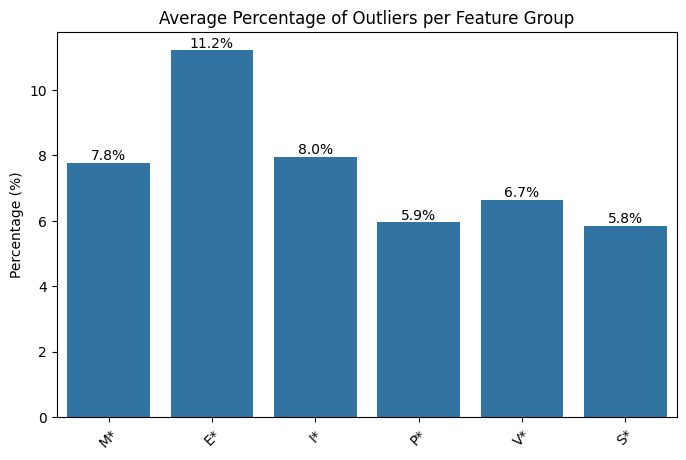

In [12]:
# Visualization for Outliers
plt.figure(figsize=(8, 5))
groups = list(outlier_summary.keys())
percentages = [outlier_summary[g]['percentage'] for g in groups]
ax = sns.barplot(x=groups, y=percentages)
for i, p in enumerate(ax.patches):
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')
plt.title('Average Percentage of Outliers per Feature Group')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.savefig('charts/outliers_summary.png')
plt.show()

In [13]:
# Handling: Bulk Clipping
def clip_group_outliers(df, group_cols, window=30):
    for col in group_cols:
        mask = detect_outliers_rolling(df, col, window=window)
        rolling_lower = df[col].rolling(window=window, min_periods=1).quantile(0.05)
        rolling_upper = df[col].rolling(window=window, min_periods=1).quantile(0.95)
        clipped = df[col].copy()
        valid_mask = ~rolling_lower.isna()
        clipped.loc[mask & valid_mask] = np.where(
            df.loc[mask & valid_mask, col] < rolling_lower,
            rolling_lower,
            rolling_upper
        )
        df[col + '_clipped'] = clipped
    return df

In [14]:
def clip_group_outliers(df, group_cols, window=30):
    clipped_count = 0
    for col in group_cols:
        if col not in df.columns:
            print(f"Warning: Column {col} not in df. Skipping.")
            continue
        try:
            mask = detect_outliers_rolling(df, col, window=window)
            rolling_lower = df[col].rolling(window=window, min_periods=1).quantile(0.05)
            rolling_upper = df[col].rolling(window=window, min_periods=1).quantile(0.95)
            
            clipped = df[col].copy()
            valid_mask = ~rolling_lower.isna()
            outlier_positions = mask & valid_mask
            
            if outlier_positions.any():
        
                lower_vals = rolling_lower.loc[outlier_positions]
                upper_vals = rolling_upper.loc[outlier_positions]
                col_vals = df.loc[outlier_positions, col]
                
                
                to_lower = col_vals < lower_vals
                clipped.loc[outlier_positions] = np.where(
                    to_lower,
                    lower_vals,
                    upper_vals  
                )
                local_clipped = outlier_positions.sum()
                clipped_count += local_clipped
                print(f"Clipped {local_clipped} values in {col}")
            else:
                print(f"No outliers to clip in {col}")
            
            df[col + '_clipped'] = clipped
        except Exception as e:
            print(f"Error clipping {col}: {e}. Skipping.")
            continue
    print(f"Total clipped values across group: {clipped_count}")
    return df

In [15]:
for group, cols in feature_groups.items():
    actual_cols = [col for col in cols if col in df_recent.columns]
    if not actual_cols:
        print(f"No columns for {group} in df_recent. Skipping.")
        continue
    df_recent = clip_group_outliers(df_recent, actual_cols, window=30)
    print(f"Clipped {group} features (used {len(actual_cols)} cols).")

Clipped 232 values in M1
Clipped 349 values in M10
Clipped 261 values in M11
Clipped 241 values in M12
Clipped 241 values in M13
Clipped 214 values in M14
Clipped 576 values in M15
Clipped 173 values in M16
Clipped 523 values in M17
Clipped 576 values in M18
Clipped 18 values in M2
Clipped 205 values in M3
Clipped 162 values in M4
Clipped 162 values in M5
Clipped 204 values in M6
Clipped 587 values in M7
Clipped 62 values in M8
Clipped 236 values in M9
Total clipped values across group: 5022
Clipped M* features (used 18 cols).
Clipped 139 values in E1
Clipped 378 values in E10
Clipped 542 values in E11
Clipped 358 values in E12
Clipped 346 values in E13
Clipped 50 values in E14
Clipped 741 values in E15
Clipped 612 values in E16
Clipped 672 values in E17
Clipped 662 values in E18
Clipped 204 values in E19
Clipped 264 values in E2
Clipped 524 values in E20
Clipped 278 values in E3
Clipped 372 values in E4
Clipped 393 values in E5
Clipped 242 values in E6
Clipped 271 values in E8
Clipped

In [16]:
df_recent.head()

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,S10_clipped,S11_clipped,S12_clipped,S2_clipped,S4_clipped,S5_clipped,S6_clipped,S7_clipped,S8_clipped,S9_clipped
0,5400,0,0,0,0,0,0,0,0,1,...,0.244709,0.230820,-0.383907,-1.179744,0.411376,0.048886,0.427910,0.290013,0.324787,0.931217
1,5401,0,0,0,0,0,0,0,0,0,...,0.702381,0.519180,0.582260,-1.564343,0.608466,0.301318,0.456349,0.289683,0.089684,0.900132
2,5402,0,0,0,0,0,0,0,0,0,...,0.597222,0.578704,-0.719695,-1.690397,0.604497,0.440876,0.550265,0.289352,-0.027119,0.876323
3,5403,0,0,0,0,0,0,0,0,0,...,0.112434,0.103175,1.984943,-1.751683,0.171296,0.617615,0.536376,0.289021,-0.128457,0.951058
4,5404,0,0,0,0,0,0,0,0,0,...,0.992063,0.823413,0.179290,-1.876788,0.755952,0.647878,0.536706,0.288690,-0.294203,0.367857


In [17]:
# Filter all clipped columns
df_handled = df_recent[
    ['date_id','forward_returns', 'risk_free_rate', 'market_forward_excess_returns'] +
    [col for col in df_recent.columns if col.startswith('D')] +
    [col for col in df_recent.columns if col.endswith('_clipped')]
].drop_duplicates()
df_handled.head()

,date_id,forward_returns,risk_free_rate,market_forward_excess_returns,D1,D2,D3,D4,D5,D6,...,S10_clipped,S11_clipped,S12_clipped,S2_clipped,S4_clipped,S5_clipped,S6_clipped,S7_clipped,S8_clipped,S9_clipped
0,5400,-0.010543,0.000001,-0.010851,0,0,0,0,0,0,...,0.244709,0.230820,-0.383907,-1.179744,0.411376,0.048886,0.427910,0.290013,0.324787,0.931217
1,5401,-0.000659,0.000001,-0.000967,0,0,0,0,0,0,...,0.702381,0.519180,0.582260,-1.564343,0.608466,0.301318,0.456349,0.289683,0.089684,0.900132
2,5402,-0.004187,0.000002,-0.004496,0,0,0,0,0,0,...,0.597222,0.578704,-0.719695,-1.690397,0.604497,0.440876,0.550265,0.289352,-0.027119,0.876323
3,5403,0.007631,0.000001,0.007323,0,0,0,0,0,0,...,0.112434,0.103175,1.984943,-1.751683,0.171296,0.617615,0.536376,0.289021,-0.128457,0.951058
4,5404,-0.013910,0.000002,-0.014219,0,0,0,0,0,0,...,0.992063,0.823413,0.179290,-1.876788,0.755952,0.647878,0.536706,0.288690,-0.294203,0.367857


In [18]:
# Save the Data
df_handled.to_csv('datasets/train_recent_10y_cleaned.csv', index=False)
print("Saved recent processed data.")

Saved recent processed data.


# 2. Exploratory Data Analysis (EDA)

In [42]:
df_cleaned = pd.read_csv('datasets/train_recent_10y_cleaned.csv')
df_cleaned.head()

,date_id,forward_returns,risk_free_rate,market_forward_excess_returns,D1,D2,D3,D4,D5,D6,...,S10_clipped,S11_clipped,S12_clipped,S2_clipped,S4_clipped,S5_clipped,S6_clipped,S7_clipped,S8_clipped,S9_clipped
0,5400,-0.010543,0.000001,-0.010851,0,0,0,0,0,0,...,0.244709,0.230820,-0.383907,-1.179744,0.411376,0.048886,0.427910,0.290013,0.324787,0.931217
1,5401,-0.000659,0.000001,-0.000967,0,0,0,0,0,0,...,0.702381,0.519180,0.582260,-1.564343,0.608466,0.301318,0.456349,0.289683,0.089684,0.900132
2,5402,-0.004187,0.000002,-0.004496,0,0,0,0,0,0,...,0.597222,0.578704,-0.719695,-1.690397,0.604497,0.440876,0.550265,0.289352,-0.027119,0.876323
3,5403,0.007631,0.000001,0.007323,0,0,0,0,0,0,...,0.112434,0.103175,1.984943,-1.751683,0.171296,0.617615,0.536376,0.289021,-0.128457,0.951058
4,5404,-0.013910,0.000002,-0.014219,0,0,0,0,0,0,...,0.992063,0.823413,0.179290,-1.876788,0.755952,0.647878,0.536706,0.288690,-0.294203,0.367857


In [43]:
# Lagged version for market forward excess returns
df_cleaned['MFER_lag1'] = df_cleaned['market_forward_excess_returns'].shift(1)
df_cleaned = df_cleaned.dropna().reset_index(drop=True)
df_cleaned = df_cleaned.drop('market_forward_excess_returns', axis=1)

## 1. Mutual Information

In [28]:
# Define targets
targets = ['forward_returns']

# Prepare features
feature_cols = [col for col in df_cleaned.columns if col not in targets and df_cleaned[col].dtype in ['int64', 'float64']]
X = df_cleaned[feature_cols].copy()

print(f"Number of features: {len(X.columns)}")
print(f"Dataset shape: {X.shape}")

Number of features: 94
Dataset shape: (3589, 94)


In [29]:
# Function to compute MI and get sorted scores
def compute_mi(X, y):
    y_clean = y.fillna(0)  # Handle any missing in target
    mi_scores = mutual_info_regression(X, y_clean, random_state=42)
    mi_df = pd.DataFrame({
        'feature': X.columns,
        'mi_score': mi_scores
    }).sort_values('mi_score', ascending=False)
    return mi_df

In [30]:
# Compute MI for each target
mi_results = {}
for target in targets:
    y = df_cleaned[target]
    mi_df = compute_mi(X, y)
    mi_results[target] = mi_df

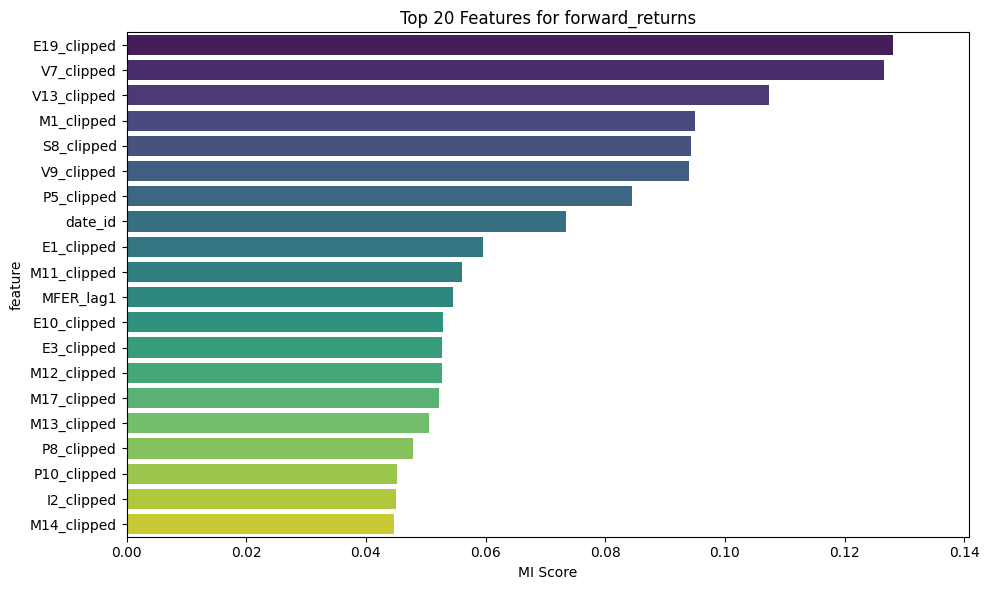

In [31]:
# Visualization: Barplot for top 20 features per target
N_TOP = 20
top_df = mi_results[target].head(N_TOP)
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title(f'Top {N_TOP} Features for {target}')
sns.barplot(data=top_df, y='feature', x='mi_score', ax=ax, palette='viridis')
ax.set_xlabel('MI Score')
ax.set_xlim(0, top_df['mi_score'].max() * 1.1)  # Buffer for readability
plt.tight_layout()
plt.savefig('charts/mi_target.png', dpi=300, bbox_inches='tight')
plt.show()

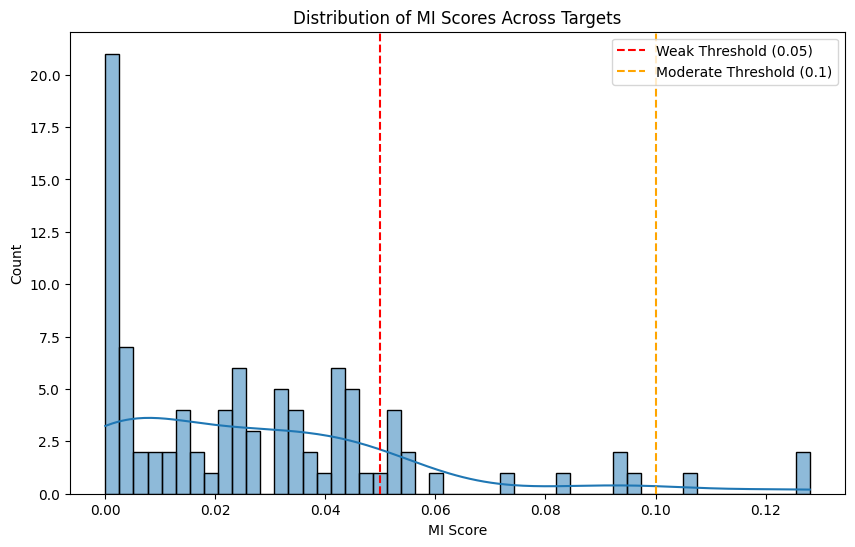

In [32]:
# Histogram
all_mis = pd.concat([df_cleaned.assign(target=k) for k, df_cleaned in mi_results.items()], ignore_index=True)
plt.figure(figsize=(10, 6))
sns.histplot(data=all_mis, x='mi_score', hue='target', kde=True, bins=50)
plt.title('Distribution of MI Scores Across Targets')
plt.xlabel('MI Score')
plt.axvline(0.05, color='r', linestyle='--', label='Weak Threshold (0.05)')
plt.axvline(0.1, color='orange', linestyle='--', label='Moderate Threshold (0.1)')
plt.legend()
plt.savefig('charts/mi_distribution.png', dpi=300)
plt.show()

In [33]:
# Function to categorize and count ranges
def categorize_mi_ranges(mi_df, total_features):
    mi = mi_df['mi_score']
    
    ranges = {
        '0-0.05': ((mi >= 0) & (mi < 0.05)).sum(),
        '0.05-0.1': ((mi >= 0.05) & (mi < 0.1)).sum(),
        '>0.1': (mi >= 0.1).sum(),
        '>0.5': (mi >= 0.5).sum()  # Subset dari >0.1
    }
    
    percentages = {k: (v / total_features * 100) for k, v in ranges.items()}
    
    # Format summary
    summary = pd.DataFrame({
        'Range': list(ranges.keys()),
        'Count': list(ranges.values()),
        'Percentage': [f"{p:.2f}%" for p in percentages.values()]
    })
    return summary

In [34]:
# Compute summary for each target
total_features = len(X.columns)
all_summaries = []
for target in mi_results.keys():
    summary = categorize_mi_ranges(mi_results[target], total_features)
    summary['Target'] = target
    all_summaries.append(summary)
    print(f"\nFor {target}:")
    print(summary.to_string(index=False))

# Combine all summaries
full_summary = pd.concat(all_summaries, ignore_index=True)
full_summary = full_summary[['Target', 'Range', 'Count', 'Percentage']]


For forward_returns:
   Range  Count Percentage          Target
  0-0.05     78     82.98% forward_returns
0.05-0.1     13     13.83% forward_returns
    >0.1      3      3.19% forward_returns
    >0.5      0      0.00% forward_returns


In [35]:
full_summary

,Target,Range,Count,Percentage
0,forward_returns,0-0.05,78,82.98%
1,forward_returns,0.05-0.1,13,13.83%
2,forward_returns,>0.1,3,3.19%
3,forward_returns,>0.5,0,0.00%


## 2. Feature Selection

In [44]:
MI_THRESHOLDS = {
    'forward_returns': 0.05,  # Medium for weak signals
}
TOP_N = None
total_features = len(X.columns)

In [37]:
# Compute MI and select features for each target
selected_features = {}
for target in targets:
    y = df_cleaned[target]
    mi_df = compute_mi(X, y)
    
    # Apply threshold or top N
    if TOP_N is not None:
        selected_df = mi_df.head(TOP_N)
    else:
        threshold = MI_THRESHOLDS.get(target, 0.05)  # Default 0.05
        selected_df = mi_df[mi_df['mi_score'] > threshold]
    
    selected_feats = selected_df['feature'].tolist()
    selected_features[target] = selected_feats
    n_selected = len(selected_feats)
    print(f"\n=== Feature Selection for '{target}' ===")
    print(f"Threshold/Top: {threshold if TOP_N is None else TOP_N}")
    print(f"Selected {n_selected}/{total_features} features (MI > {threshold if TOP_N is None else 'top criteria'})")
    print("Selected features:", selected_feats)
    
    # Save to CSV
    selected_df.to_csv(f'selected_features_{target.replace(" ", "_").replace("/", "_")}.csv', index=False)
    print(f"Saved to 'selected_features_{target.replace(" ", "_").replace("/", "_")}.csv'")


=== Feature Selection for 'forward_returns' ===
Threshold/Top: 0.05
Selected 16/94 features (MI > 0.05)
Selected features: ['E19_clipped', 'V7_clipped', 'V13_clipped', 'M1_clipped', 'S8_clipped', 'V9_clipped', 'P5_clipped', 'date_id', 'E1_clipped', 'M11_clipped', 'MFER_lag1', 'E10_clipped', 'E3_clipped', 'M12_clipped', 'M17_clipped', 'M13_clipped']
Saved to 'selected_features_forward_returns.csv'


# 3. Further EDA

In [45]:
# Select columns
selected_return = pd.read_csv('datasets/selected_features_forward_returns.csv')

df_return = df_cleaned[selected_return['feature']]
df_return['forward_returns'] = df_cleaned['forward_returns']

print('Return shape: ', df_return.shape)

Return shape:  (3589, 17)


## 1. Split Data for Training and Demo Testing

In [46]:
# Sorting Data by date_id
df_return = df_return.sort_values('date_id')

# Split Data, 20% as a test
split_idx = int(0.8 * len(df_return))

# Splitting Data
train_df_return = df_return.iloc[:split_idx].copy()
test_df_return = df_return.iloc[split_idx:].copy()


## 2. Robust Scaling

In [47]:
# Import Library
from sklearn.preprocessing import RobustScaler
scaler_rate = RobustScaler()
scaler_return = RobustScaler()

In [48]:
# Features
cols_return = [col for col in train_df_return.columns if col not in ['date_id', 'forward_returns']]


In [49]:
# Fit and transform Return
# Train
train_df_return_scaled = train_df_return.copy()
train_features_return = train_df_return[cols_return].values
train_features_return_scaled = scaler_return.fit_transform(train_features_return)
train_df_return_scaled[cols_return] = pd.DataFrame(train_features_return_scaled, 
                                                    columns=cols_return, 
                                                    index=train_df_return.index)
train_df_return_scaled['forward_returns'] = train_df_return['forward_returns']

test_df_return_scaled = test_df_return.copy()
test_features_return = test_df_return[cols_return].values
test_features_return_scaled = scaler_return.transform(test_features_return)
test_df_return_scaled[cols_return] = pd.DataFrame(test_features_return_scaled, 
                                                   columns=cols_return, 
                                                   index=test_df_return.index)
test_df_return_scaled['forward_returns'] = test_df_return['forward_returns']

train_df_return_scaled.to_csv('datasets/train_df_return_scaled.csv', index=False)
test_df_return_scaled.to_csv('datasets/test_df_return_scaled.csv', index=False)
print('Files Saved')

Files Saved


# 4. Baseline Model

<p>For the baseline model, I will use a simple model, namely <b>Linear Regression</b>, as a reference going forward.</p>


In [2]:
# Load the data train and test
df_train = pd.read_csv('datasets/train_df_return_scaled.csv')
df_test = pd.read_csv('datasets/test_df_return_scaled.csv')
print('Shapes of df_train: ', df_train.shape)
print('Shapes of df_test: ', df_test.shape)

Shapes of df_train:  (2871, 17)
Shapes of df_test:  (718, 17)


In [3]:
df_train.columns

Index(['E19_clipped', 'V7_clipped', 'V13_clipped', 'M1_clipped', 'S8_clipped',
       'V9_clipped', 'P5_clipped', 'date_id', 'E1_clipped', 'M11_clipped',
       'MFER_lag1', 'E10_clipped', 'E3_clipped', 'M12_clipped', 'M17_clipped',
       'M13_clipped', 'forward_returns'],
      dtype='object')

In [6]:
# Splits X for training and testing
feature_columns_train = [col for col in df_train.columns if col not in ['forward_returns']]
feature_columns_test = [col for col in df_test.columns if col not in ['forward_returns']]

X_train = df_train[feature_columns_train]
X_test = df_test[feature_columns_test]

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

baseline_model = LinearRegression()

baseline_model.fit(X_train, df_train['forward_returns'])
y_pred = baseline_model.predict(X_test)
score = np.sqrt(mean_squared_error(df_test['forward_returns'],y_pred)) #RMSE for the matric

print(f"Mean RMSE: {np.mean(score):.4f}")


Mean RMSE: 0.0094


# 5. Feature Engineering

In [2]:
# Load the data train and test
df_train = pd.read_csv('datasets/train_df_return_scaled.csv')
df_test = pd.read_csv('datasets/test_df_return_scaled.csv')

df_select = pd.concat([df_train, df_test], ignore_index=True)
df_select = df_select.sort_values('date_id')
df_select.head()

,E19_clipped,V7_clipped,V13_clipped,M1_clipped,S8_clipped,V9_clipped,P5_clipped,date_id,E1_clipped,M11_clipped,MFER_lag1,E10_clipped,E3_clipped,M12_clipped,M17_clipped,M13_clipped,forward_returns
0,0.034891,0.059970,0.150674,1.639215,-0.183943,0.032507,-0.491767,5401,0.819098,0.901213,-1.191672,-0.760564,-0.777379,0.912513,0.241566,0.9621,-0.000659
1,-0.165770,0.031988,0.110542,1.639215,-0.267280,0.001126,-0.543677,5402,0.812990,0.934388,-0.136611,-0.761081,-0.779102,0.875916,0.240596,0.9621,-0.004187
2,0.186479,0.079123,0.185184,1.639215,-0.339582,0.031215,-0.489903,5403,0.806910,0.879442,-0.513318,-0.761598,-0.788310,0.895604,0.239626,0.9621,0.007631
3,-0.170866,0.011608,0.074340,1.639215,-0.457839,-0.015710,-0.541719,5404,0.800858,0.946433,0.748193,-0.762115,-0.770804,0.926104,0.238655,0.9621,-0.013910
4,0.452550,0.083140,0.172681,1.639215,-0.471097,0.041427,-0.479229,5405,0.794833,0.871191,-1.551133,-0.762633,-0.802803,0.955429,0.240596,0.9621,0.000784


In [3]:
# Only take the top 10 features
selected_features = pd.read_csv('datasets/selected_features_forward_returns.csv')

df_fe = df_select[selected_features['feature'].head(10)]
df_fe['forward_returns'] = df_select['forward_returns']
df_fe.head()

,E19_clipped,V7_clipped,V13_clipped,M1_clipped,S8_clipped,V9_clipped,P5_clipped,date_id,E1_clipped,M11_clipped,forward_returns
0,0.034891,0.059970,0.150674,1.639215,-0.183943,0.032507,-0.491767,5401,0.819098,0.901213,-0.000659
1,-0.165770,0.031988,0.110542,1.639215,-0.267280,0.001126,-0.543677,5402,0.812990,0.934388,-0.004187
2,0.186479,0.079123,0.185184,1.639215,-0.339582,0.031215,-0.489903,5403,0.806910,0.879442,0.007631
3,-0.170866,0.011608,0.074340,1.639215,-0.457839,-0.015710,-0.541719,5404,0.800858,0.946433,-0.013910
4,0.452550,0.083140,0.172681,1.639215,-0.471097,0.041427,-0.479229,5405,0.794833,0.871191,0.000784


In [4]:
df_fe.shape


(3589, 11)

## 1. Lagging Features and Delta Changes

In [ ]:
# Lagging
lag_cols = [col for col in df_fe.columns if col not in ['forward_returns','date_id']]

lagging_feat = df_fe[lag_cols]

for i in range(1, 4):
    for col in lag_cols:
        lagging_feat[f'{col}_lag{i}'] = lagging_feat[col].shift(i)

lagging_feat = lagging_feat.fillna(0)
lagging_feat.head()

,E19_clipped,V7_clipped,V13_clipped,M1_clipped,S8_clipped,V9_clipped,P5_clipped,E1_clipped,M11_clipped,E19_clipped_lag1,...,M11_clipped_lag2,E19_clipped_lag3,V7_clipped_lag3,V13_clipped_lag3,M1_clipped_lag3,S8_clipped_lag3,V9_clipped_lag3,P5_clipped_lag3,E1_clipped_lag3,M11_clipped_lag3
0,0.034891,0.059970,0.150674,1.639215,-0.183943,0.032507,-0.491767,0.819098,0.901213,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.165770,0.031988,0.110542,1.639215,-0.267280,0.001126,-0.543677,0.812990,0.934388,0.034891,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.186479,0.079123,0.185184,1.639215,-0.339582,0.031215,-0.489903,0.806910,0.879442,-0.165770,...,0.901213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-0.170866,0.011608,0.074340,1.639215,-0.457839,-0.015710,-0.541719,0.800858,0.946433,0.186479,...,0.934388,0.034891,0.059970,0.150674,1.639215,-0.183943,0.032507,-0.491767,0.819098,0.901213
4,0.452550,0.083140,0.172681,1.639215,-0.471097,0.041427,-0.479229,0.794833,0.871191,-0.170866,...,0.879442,-0.165770,0.031988,0.110542,1.639215,-0.267280,0.001126,-0.543677,0.812990,0.934388


In [6]:
# Add change columns: original - lag1
for col in lag_cols:
    lagging_feat[f'{col}_change'] = lagging_feat[col] - lagging_feat[f'{col}_lag1']

lagging_feat.head()


,E19_clipped,V7_clipped,V13_clipped,M1_clipped,S8_clipped,V9_clipped,P5_clipped,E1_clipped,M11_clipped,E19_clipped_lag1,...,M11_clipped_lag3,E19_clipped_change,V7_clipped_change,V13_clipped_change,M1_clipped_change,S8_clipped_change,V9_clipped_change,P5_clipped_change,E1_clipped_change,M11_clipped_change
0,0.034891,0.059970,0.150674,1.639215,-0.183943,0.032507,-0.491767,0.819098,0.901213,0.000000,...,0.000000,0.034891,0.059970,0.150674,1.639215,-0.183943,0.032507,-0.491767,0.819098,0.901213
1,-0.165770,0.031988,0.110542,1.639215,-0.267280,0.001126,-0.543677,0.812990,0.934388,0.034891,...,0.000000,-0.200660,-0.027982,-0.040131,0.000000,-0.083337,-0.031381,-0.051910,-0.006108,0.033175
2,0.186479,0.079123,0.185184,1.639215,-0.339582,0.031215,-0.489903,0.806910,0.879442,-0.165770,...,0.000000,0.352249,0.047136,0.074642,0.000000,-0.072303,0.030090,0.053773,-0.006080,-0.054946
3,-0.170866,0.011608,0.074340,1.639215,-0.457839,-0.015710,-0.541719,0.800858,0.946433,0.186479,...,0.901213,-0.357345,-0.067516,-0.110844,0.000000,-0.118257,-0.046925,-0.051816,-0.006052,0.066991
4,0.452550,0.083140,0.172681,1.639215,-0.471097,0.041427,-0.479229,0.794833,0.871191,-0.170866,...,0.934388,0.623416,0.071532,0.098341,0.000000,-0.013257,0.057137,0.062490,-0.006025,-0.075242


In [7]:
# Adding a date_id and forward_returns
lagging_feat['date_id'] = df_fe['date_id']
lagging_feat['forward_returns'] = df_fe['forward_returns']

lagging_feat.to_csv('datasets/df_fe.csv', index=False)
print('File Saved!')


File Saved!


## 2. Calendar Feature

In [2]:
df_fe = pd.read_csv('datasets/df_fe.csv')
df_fe.shape

(3589, 47)

In [5]:
df_fe = df_fe.sort_values('date_id')
df_fe['date_id']

0       5401
1       5402
2       5403
3       5404
4       5405
        ... 
3584    8985
3585    8986
3586    8987
3587    8988
3588    8989
Name: date_id, Length: 3589, dtype: int64

In [6]:
# Make feature day_of_week and month
df_fe['day_of_week'] = (((df_fe['date_id'] - 5401) // 5) % 4) + 1
df_fe['month'] = (((df_fe['date_id'] - 5401) // 30) % 12) + 1

df_fe[['day_of_week','month']].head()

,day_of_week,month
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


In [8]:
df_fe.shape

(3589, 49)

In [9]:
df_fe.to_csv('datasets/df_fe.csv', index=False)
print('File Saved!')

File Saved!


## 3. Rolling Statics

In [3]:
# Load Data
df_fe = pd.read_csv('datasets/df_fe.csv')
df_fe = df_fe.sort_values('date_id')
df_fe.shape

(3589, 49)

In [4]:
# Rolling window
selected_features = pd.read_csv('datasets/selected_features_forward_returns.csv')
df_roll = df_fe[selected_features['feature'].head(10)]
roll_cols = [col for col in df_roll.columns if col not in ['forward_returns','date_id']]

# Rolling Window 5 (mean)
for col in roll_cols:
    if col in df_roll.columns:
        df_roll[f'{col}_ma5'] = df_roll[col].rolling(window=5).mean()

# Rolling Window 10 (STD)
for col in roll_cols:
    if col in df_roll.columns:
        df_roll[f'{col}_std10'] = df_roll[col].rolling(window=10).std()

df_roll = df_roll.fillna(0)
df_roll.head()

,E19_clipped,V7_clipped,V13_clipped,M1_clipped,S8_clipped,V9_clipped,P5_clipped,date_id,E1_clipped,M11_clipped,...,M11_clipped_ma5,E19_clipped_std10,V7_clipped_std10,V13_clipped_std10,M1_clipped_std10,S8_clipped_std10,V9_clipped_std10,P5_clipped_std10,E1_clipped_std10,M11_clipped_std10
0,0.034891,0.059970,0.150674,1.639215,-0.183943,0.032507,-0.491767,5401,0.819098,0.901213,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.165770,0.031988,0.110542,1.639215,-0.267280,0.001126,-0.543677,5402,0.812990,0.934388,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.186479,0.079123,0.185184,1.639215,-0.339582,0.031215,-0.489903,5403,0.806910,0.879442,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.170866,0.011608,0.074340,1.639215,-0.457839,-0.015710,-0.541719,5404,0.800858,0.946433,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.452550,0.083140,0.172681,1.639215,-0.471097,0.041427,-0.479229,5405,0.794833,0.871191,...,0.906533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Adding rolling results
df_fe[df_roll.columns[df_roll.columns.str.endswith(("ma5", "std10"))]] = df_roll[df_roll.columns[df_roll.columns.str.endswith(("ma5", "std10"))]]
df_fe.shape

(3589, 67)

In [6]:
# Saving the results
df_fe.to_csv('datasets/df_fe.csv', index=False)
print('File Saved!')

File Saved!


## 4. Feature Interactions

In [7]:
# Load Data
df_fe = pd.read_csv('datasets/df_fe.csv')
df_fe = df_fe.sort_values('date_id')
df_fe.shape

(3589, 67)

<h3>1. Inter-feat</h3>

In [8]:
# Prod
df_fe['V7_S8_prod'] = df_fe['V7_clipped'] * df_fe['S8_clipped']
df_fe['V7_P5_prod'] = df_fe['V7_clipped'] * df_fe['P5_clipped']
df_fe['E19_M1_prod'] = df_fe['E19_clipped'] * df_fe['M1_clipped']

<h3>2. Intra-feat</h3>

In [9]:
df_fe['V7_V9_prod'] = df_fe['V7_clipped'] * df_fe['V9_clipped']
df_fe['V7_V9_diff'] = df_fe['V7_clipped'] - df_fe['V9_clipped']
df_fe['V7_V13_prod'] = df_fe['V7_clipped'] * df_fe['V13_clipped']

<h3>3. Ratio</h3>

In [10]:
eps = 1e-6
df_fe['P5_V7_ratio'] = df_fe['P5_clipped'] / (df_fe['V7_clipped'] + eps)
df_fe['P5_E19_ratio'] = df_fe['P5_clipped'] / (df_fe['E19_clipped'] + eps)

In [11]:
df_fe.shape

(3589, 75)

In [12]:
# Saving the results
df_fe.to_csv('datasets/df_fe.csv', index=False)
print('File Saved!')

File Saved!


## 5. Market Regime

In [2]:
# Load Data
df_fe = pd.read_csv('datasets/df_fe.csv')
df_fe = df_fe.sort_values('date_id')
df_fe.shape

(3589, 75)

<h3>1. Lagging Forward Returns</h3>

In [5]:
df_fe['forward_returns_lag1'] = df_fe['forward_returns'].shift(1)
df_fe['forward_returns_lag2'] = df_fe['forward_returns'].shift(2)
df_fe[['forward_returns_lag1','forward_returns_lag2']].head()

,forward_returns_lag1,forward_returns_lag2
0,NaN,NaN
1,-0.000659,NaN
2,-0.004187,-0.000659
3,0.007631,-0.004187
4,-0.013910,0.007631


<h3>2. Dummy Regime</h3>

In [6]:
# 1 if market bear
df_fe['is_bear'] = (df_fe['forward_returns'].rolling(20).mean() < 0).astype(int)
df_fe['is_bear'].head()

0    0
1    0
2    0
3    0
4    0
Name: is_bear, dtype: int64

<h3>3. Target Volatility</h3>

In [7]:
# Volatility for forward_returns
df_fe['forward_returns_vol'] = df_fe['forward_returns'].rolling(window=20).std()
df_fe[['date_id','forward_returns_vol']].tail()

,date_id,forward_returns_vol
3584,8985,0.005912
3585,8986,0.005879
3586,8987,0.005459
3587,8988,0.005690
3588,8989,0.005690


In [8]:
df_fe.shape

(3589, 79)

In [9]:
# Saving the results
df_fe.to_csv('datasets/df_fe.csv', index=False)
print('File Saved!')

File Saved!


## 6. Features Selection